In [1]:
import pandas as pd 
# import nltk
# nltk.download('punkt') # one time execution
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from nltk.tokenize import sent_tokenize


In [2]:
# train = pd.read_csv('../dataset/train_sample.csv')
# train = pd.read_csv('../dataset/train.csv')
# test = pd.read_csv('../dataset/test.csv')
# valid = pd.read_csv('../dataset/validation.csv')
# data = pd.concat([train, test, valid], axis=0)
# data = data.head(100)
# data

# data = pd.read_csv('../dataset/train.csv')
data=pd.read_csv('../dataset/train.csv')
data = data.head(10000)
# data = data.sample(frac=0.2, random_state=42)

In [3]:
# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

### TF-IDF 句子结构

In [4]:


# 示例句子
sentences = [
    "This is a sample sentence.",
    "This is another sample sentence.",
    "Completely different sentence."
]

# 初始化TF-IDF向量化器
vectorizer = TfidfVectorizer()

# 构建TF-IDF矩阵
tfidf_matrix = vectorizer.fit_transform(sentences)

# 计算第一个句子与其他句子的相似度
cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])

print(cosine_similarities)


[[0.82203923 0.15766434]]


In [5]:

# 预处理函数，这里简化为仅分割句子，实际应用中可能需要更复杂的处理
def preprocess(text):
    text = text.strip().lower()
    text = sent_tokenize(text)
    return text

# 准备所有句子用于训练TF-IDF
all_sentences = []
for _, row in data.iterrows():
    all_sentences.extend(preprocess(row['article']))
    # all_sentences.extend(preprocess(row['highlights']))

# 训练TF-IDF向量化器
# vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words='english')
vectorizer = TfidfVectorizer(stop_words='english')

vectorizer.fit(all_sentences)



TfidfVectorizer(stop_words='english')

In [6]:

# 定义一个函数计算并返回每个highlight与article中最相似句子的索引
def find_most_similar_highlight(row):
    article_sentences = preprocess(row['article'])
    highlight_sentences = preprocess(row['highlights'])
    
    # 得到TF-IDF向量
    article_tfidf = vectorizer.transform(article_sentences)
    highlights_tfidf = vectorizer.transform(highlight_sentences)
    
    # 计算相似度并找到最相似的句子
    similarity_matrix = cosine_similarity(highlights_tfidf, article_tfidf)
    
    # 对于每个highlight，找到与其最相似的文章句子的索引
    most_similar_indices = similarity_matrix.argmax(axis=1)

    # partitions
    relative_positions = (most_similar_indices + 1) / len(article_sentences) * 100

    # the positional index falls into the bins
    # 定义20个分箱的边界（0到100之间等间隔的21个点）
    bins = np.linspace(0, 100, num=51)

    # 使用digitize找出每个位置所属的分箱
    bin_indices = np.digitize(relative_positions, bins=bins, right=True)
    
    return most_similar_indices, bin_indices


In [7]:
np.linspace(0, 100, num=21)

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

In [8]:
data[['most_similar_indices', 'bin_indices']] = data.apply(find_most_similar_highlight, axis=1, result_type='expand')

In [9]:
key_sentence_position = []
for s in data['bin_indices'].tolist():
    for i in list(s):
        key_sentence_position.append(i)

In [10]:
len(key_sentence_position)

36641

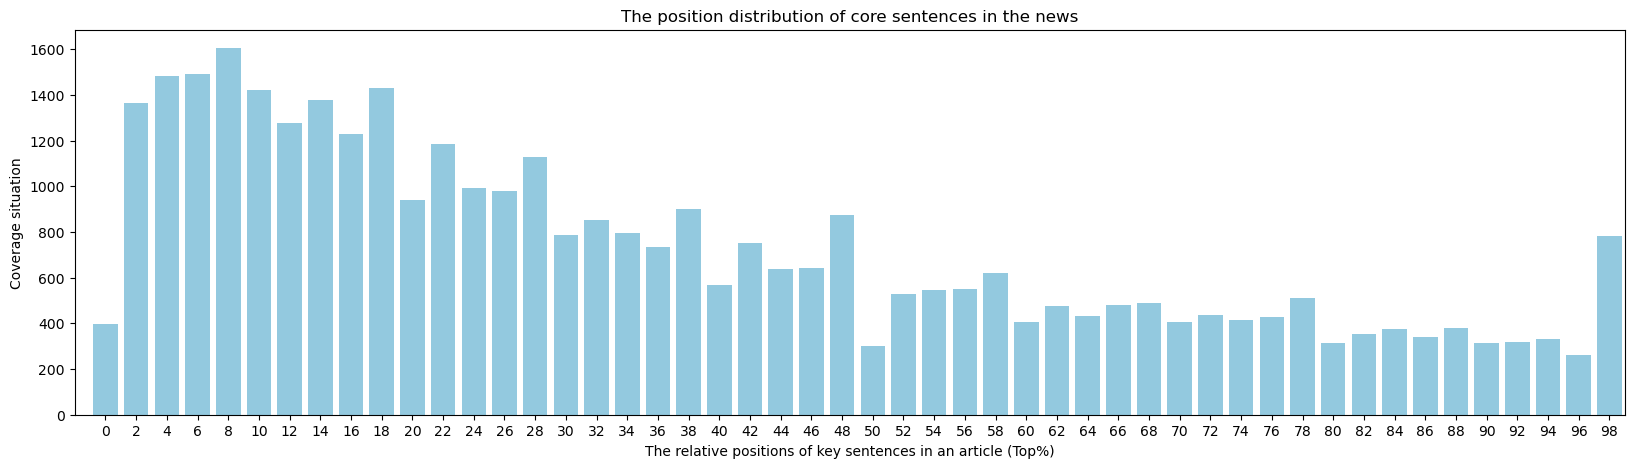

In [12]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
sns.countplot(x=key_sentence_position, color='skyblue')

# 定义你的bins边界
bins_edges = np.linspace(0, 100, num=51)

# 因为你的countplot中应该有20个bins，我们要确保xticks中的数量与bins_edges匹配
plt.xticks(ticks=np.arange(0, 50), labels=bins_edges[:-1].astype(int))
plt.xlim(-1)
plt.xlabel('The relative positions of key sentences in an article (Top%)')
plt.ylabel('Coverage situation')
plt.title('The position distribution of core sentences in the news')
plt.savefig('sentence_distribution.png', dpi=300)
plt.show()


<Axes: ylabel='Density'>

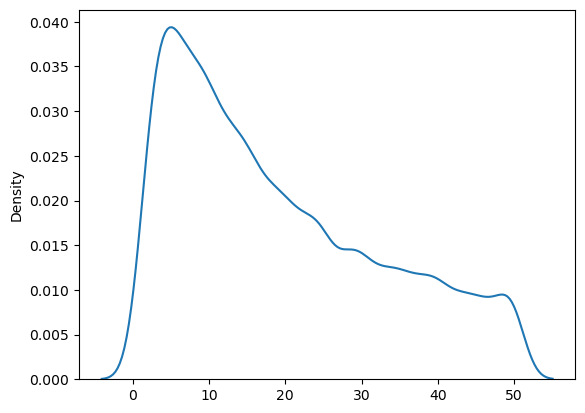

In [14]:
sns.kdeplot(key_sentence_position)

In [15]:
data

,id,article,highlights,most_similar_indices,bin_indices
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ...","[11, 11, 7]","[43, 43, 29]"
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...,"[6, 0, 3]","[20, 3, 12]"
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t...","[5, 17, 3, 16, 6]","[10, 28, 7, 26, 11]"
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...,"[13, 14, 19]","[32, 35, 46]"
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...,"[0, 2, 15, 18, 20, 22]","[3, 7, 34, 40, 44, 48]"
...,...,...,...,...,...
9995,1c5f649f94e8f20b6fe624a842302208b781edbc,A renowned poet was murdered by her stepson in...,Police found writer's body dead after family r...,"[1, 5, 0, 6, 0]","[6, 17, 3, 20, 3]"
9996,1c5f8a16032bff0ac292e80d33d9c473323db7aa,(Health.com) -- A class of injectable drugs us...,The research contradicts numerous earlier stud...,"[1, 6, 13]","[4, 11, 22]"
9997,1c6060b597d97f86d96e7df9ecfc29517f7bbae4,By . Rob Cooper . A mother who accidentally lo...,"Nicola Millar, 36, was unable to pay the fee a...","[3, 6, 15, 23]","[7, 12, 26, 39]"
9998,1c613f908ae6868f2d43cfe5ac75c5d35bfd734b,They are hated by many as an eyesore on the co...,Google is developing machines which will be t...,"[4, 14, 10, 15]","[12, 36, 27, 39]"


In [38]:
article_text = data.loc[9996, 'article']
article_sentences = preprocess(article_text)

article_tfidf = vectorizer.transform(article_sentences)
article_tfidf.toarray().shape

(33, 94352)

In [39]:

highlight_text = data.loc[1, 'highlights']
highlight_sentences = preprocess(highlight_text)
# highlight_sentences
highlights_tfidf = vectorizer.transform(highlight_sentences)
highlights_tfidf.toarray().shape

(3, 94352)

In [40]:
similarity_matrix = cosine_similarity(highlights_tfidf, article_tfidf)

# 对于每个highlight，找到与其最相似的文章句子的索引
most_similar_indices = similarity_matrix.argmax(axis=1)

In [41]:
similarity_matrix.shape

(3, 33)

In [42]:
most_similar_indices

array([ 0, 29,  0])

In [43]:
np.array(article_sentences)[most_similar_indices] #[11]

array(["(health.com) -- a class of injectable drugs used to treat autoimmune disorders such as rheumatoid arthritis doesn't raise the risk of serious infection when compared with more conventional treatments, according to a new analysis in the journal of the american medical association.",
       'as he notes in his editorial, some 40% of participants taking tnf inhibitors dropped out within the first month, compared with only 15% in the comparison group.',
       "(health.com) -- a class of injectable drugs used to treat autoimmune disorders such as rheumatoid arthritis doesn't raise the risk of serious infection when compared with more conventional treatments, according to a new analysis in the journal of the american medical association."],
      dtype='<U328')

In [44]:
highlight_sentences

['criminal complaint: cop used his role to help cocaine traffickers .',
 'ralph mata, an internal affairs lieutenant, allegedly helped group get guns .',
 'he also arranged to pay two assassins in a murder plot, a complaint alleges .']

In [30]:
# vectorizer.transform(article_text)

In [27]:
article_text

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# 示例文本
text = ["Python is a widely used programming language. It is popular among developers for its simplicity and versatility. Python supports multiple programming paradigms and is used in a variety of applications."]

# 初始化TF-IDF向量化器，去除英文停用词
vectorizer = TfidfVectorizer(stop_words='english')

# 计算TF-IDF
X = vectorizer.fit_transform(text)

# 获取TF-IDF权重矩阵
feature_array = np.array(vectorizer.get_feature_names_out())
tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]

# 选择关键词的数量
n = 5

# 获取最高TF-IDF值的前n个词汇作为关键词
top_n = feature_array[tfidf_sorting][:n]

print(top_n)


['used' 'python' 'programming' 'widely' 'versatility']
